# PROJECT BoardGamesGeek (BGG)

In thi project the target is to explore aspect based sentiment analysis in boardgames

Importing all modules requested

In [195]:
# set up
import pandas as pd
import numpy as np

# for XML data retrieval
import requests
import xml.etree.ElementTree as ET # to parse xml data
import io

# data extraction
import json # not needed
from tqdm.notebook import tqdm
from collections import defaultdict

# Load SpaCy's English model
import spacy
# nlp = spacy.load("en_core_web_lg") #large model
nlp = spacy.load('en_core_web_sm') #small model
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
# if not downloaded yet, use it below for position_tagger
nltk.download('averaged_perceptron_tagger')

# to do clustering with word embedding
from gensim.models import Word2Vec
from gensim.models import KeyedVectors # for default model
from gensim.test.utils import datapath # to refer to datapath of google model

# for PCA manifold
from sklearn.manifold import TSNE

# to perform sentiment classification
from textblob import TextBlob
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

# to generate dashboard/charts
import matplotlib.pyplot as plt
import seaborn as sns

# warnings
import warnings
warnings.filterwarnings('ignore')

# other various
import math
import time #to count time
import langid #for language identification and filtering

# to sort list with sorted function and using itemgetter
import operator

# to be used to avoid miss-spelled words if present in any
import enchant
d = enchant.Dict("en_US") 

# ## not used
# from transformers import pipeline
# sentiment_pipeline = pipeline('sentiment-analysis') # Initialize the sentiment analysis pipelinex

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\ZStravij\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


## 1. (--> long time needed!: to be run only once at the beginning): DATA PREPARATION

- This part show how to get the BGG dataset through the specific API.
- We create a specific dataset that it stored as csv file for later used.
- Threfore it is just executed at the first run of the project/script.

Thanks to API we can access to data in XML format, please look at following example link for output
- https://boardgamegeek.com/xmlapi2/thing?id=193738&type=boardgame&comments=1&stats=1&pagesize=100&page=1

### 1.1 Retrieve game information

In this first part we create simple a dataframe with the information of the top 15 boardgames

In [196]:
## Function to retrieve games information
def extract_info_game(url_input):   
    response = requests.get(url_input)
    xml_data = response.content
    # Parse the XML data
    root = ET.fromstring(xml_data)
    # Iterate over each "item" element of the BGG webpage in XML to retrieve game metadata
    for item in root.findall('item'):
        # Extract metadata: game id, name, year, etc.
        game_id = item.attrib['id']
        game_name = item.find('name').attrib['value']
        year_published = item.find('yearpublished').attrib.get('value', None)
        min_player = item.find('minplayers').attrib['value']
        max_player = item.find('maxplayers').attrib['value']
        play_time = item.find('playingtime').attrib['value']
        avg_score = item.find(".//average").attrib.get('value', '')
        avg_weight = item.find(".//averageweight").attrib.get('value', '')
        n_comment = item.find('comments').attrib['totalitems']   
    # Create the dataframe in which game data are stored
    df = pd.DataFrame({
        'Game_ID': [game_id],
        'Game_Name': [game_name],
        'Year_Published': [year_published],
        'Min_Players': [min_player],
        'Max_Players': [max_player],
        'Playtime': [play_time],
        'Avg_Score': [avg_score],
        'Avg_Weights': [avg_weight],
        'N_Comments': [n_comment]   
    })
    # print(df.shape) # to debug dimensions
    return df

In [197]:
# run one example of game info
id_game="193738"
id_page=str(1)
url_root1 = "https://boardgamegeek.com/xmlapi2/thing?id="
url_root2 = "&type=boardgame&comments=1&stats=1&pagesize=100&page="
url_test = url_root1+id_game+url_root2+id_page
df_test = extract_info_game(url_test)
df_test

,Game_ID,Game_Name,Year_Published,Min_Players,Max_Players,Playtime,Avg_Score,Avg_Weights,N_Comments
0,193738,Great Western Trail,2016,2,4,150,8.18359,3.7006,5343


In [198]:
# List of ids of top 15 boargames to be used with url API, game_id are taken manually
list_top15 = [174430,161936,233078,115746,187645,291457,220308,12333,182028,193738,224517,342942,316554,167791,162886]

# Create an empty dataframe to collect all games metadata
df_games = pd.DataFrame(columns=['Game_ID','Game_Name','Year_Published','Min_Players','Max_Players','Playtime','Avg_Score','Avg_Weights','N_Comments'])

for game_i in tqdm(list_top15):
    url_game=url_root1+str(game_i)+url_root2+id_page
    df_game = extract_info_game(url_game)
    df_games = pd.concat([df_games, df_game],ignore_index=True)
df_games

  0%|          | 0/15 [00:00<?, ?it/s]

,Game_ID,Game_Name,Year_Published,Min_Players,Max_Players,Playtime,Avg_Score,Avg_Weights,N_Comments
0,174430,Gloomhaven,2017,1,4,120,8.57866,3.911,11029
1,161936,Pandemic Legacy: Season 1,2015,2,4,60,8.52367,2.8295,8119
2,233078,Twilight Imperium: Fourth Edition,2017,3,6,480,8.59064,4.3276,3674
3,115746,War of the Ring: Second Edition,2011,2,4,180,8.54622,4.2146,3790
4,187645,Star Wars: Rebellion,2016,2,4,240,8.41892,3.7416,4995
5,291457,Gloomhaven: Jaws of the Lion,2020,1,4,120,8.4196,3.6413,5115
6,220308,Gaia Project,2017,1,4,150,8.37151,4.3952,3958
7,12333,Twilight Struggle,2005,2,2,180,8.24325,3.6098,10149
8,182028,Through the Ages: A New Story of Civilization,2015,2,4,120,8.27802,4.4365,4783
9,193738,Great Western Trail,2016,2,4,150,8.18359,3.7006,5343


### 1.2 Retrieve comments for games

In this second part we extract in an iterative way all the comments needed with following function

In [199]:
## Function to extract comments   information
def extract_comments_BGG_new(url_input):
    response = requests.get(url_input)
    time.sleep(2) # Sleep for 2 seconds is needed to wait for response because server could limit the iterative requests
    xml_data = response.content
    # Parse the XML data
    root = ET.fromstring(xml_data)
    # Define lists to store the comments, ratings, etc
    game_ids = []
    comment_texts = []
    comment_ratings = []    
    # Iterate over the specific element in the XML webage of BGG
    for item in root.findall('item'):
        # Extract game id
        game_id = item.attrib['id']
        # Extract all comments present in the webpage
        for comment in item.findall(".//comment"):
            comment_text = comment.attrib.get('value', '')
            comment_rating = comment.attrib.get('rating', '')
            # Append game info and comment to created lists
            game_ids.append(game_id)
            comment_texts.append(comment_text)
            comment_ratings.append(comment_rating)
    # Create the final dataframe for output
    df = pd.DataFrame({
        'Game_ID': game_ids,
        'Comment': comment_texts,
        'Comment_Rating': comment_ratings,
    })
    # check if some error occured during server connection (workaround to be used time.spleep(2)
    if df.shape[0]==0:
        print("Error retrieving data from url:", url_input)
    return df

Dataframe df_games is used to have the number of comments to interrogate iteratively the url webpages, since the limit of comments is 100 for each webpage accessed through the API rules.

In [200]:
# Create the empty dataframe to store comments and comment rating
df_all = pd.DataFrame(columns=['Game_ID','Comment','Comment_Rating'])

# start time
start = time.time()

# Iter through all list of games and all pages
for k, game_i in enumerate(tqdm(list_top15)): #for game_i in tqdm(list_top15):
    n_pages = math.ceil(int(df_games.iloc[k]['N_Comments'])/100)+1
    print("Game ID: ",df_games.iloc[k]['Game_ID']," -> with n. of comments: ",int(df_games.iloc[k]['N_Comments'])," and number of pages: ",n_pages)
    # for i in range(1,2,1): # for i in tqdm(range(n_pages-3,n_pages,1),leave=False):
    for i in tqdm(range(1,n_pages,1)):
        url_com=url_root1+str(game_i)+url_root2+str(i)
        df_com = extract_comments_BGG_new(url_com)
        df_all = pd.concat([df_all, df_com],ignore_index=True)
# end time
end = time.time()
elapsed = end - start
print("Time needed in min: ", round(elapsed/60,2), " -> Time needed in sec: ", round(elapsed,2))

# show extracted dataframe
df_all

  0%|          | 0/15 [00:00<?, ?it/s]

Game ID:  174430  -> with n. of comments:  11029  and number of pages:  112


  0%|          | 0/111 [00:00<?, ?it/s]

Game ID:  161936  -> with n. of comments:  8119  and number of pages:  83


  0%|          | 0/82 [00:00<?, ?it/s]

Game ID:  233078  -> with n. of comments:  3674  and number of pages:  38


  0%|          | 0/37 [00:00<?, ?it/s]

Game ID:  115746  -> with n. of comments:  3790  and number of pages:  39


  0%|          | 0/38 [00:00<?, ?it/s]

Game ID:  187645  -> with n. of comments:  4995  and number of pages:  51


  0%|          | 0/50 [00:00<?, ?it/s]

Game ID:  291457  -> with n. of comments:  5115  and number of pages:  53


  0%|          | 0/52 [00:00<?, ?it/s]

Game ID:  220308  -> with n. of comments:  3958  and number of pages:  41


  0%|          | 0/40 [00:00<?, ?it/s]

Game ID:  12333  -> with n. of comments:  10149  and number of pages:  103


  0%|          | 0/102 [00:00<?, ?it/s]

Game ID:  182028  -> with n. of comments:  4783  and number of pages:  49


  0%|          | 0/48 [00:00<?, ?it/s]

Game ID:  193738  -> with n. of comments:  5343  and number of pages:  55


  0%|          | 0/54 [00:00<?, ?it/s]

Game ID:  224517  -> with n. of comments:  6684  and number of pages:  68


  0%|          | 0/67 [00:00<?, ?it/s]

Game ID:  342942  -> with n. of comments:  6211  and number of pages:  64


  0%|          | 0/63 [00:00<?, ?it/s]

Game ID:  316554  -> with n. of comments:  6398  and number of pages:  65


  0%|          | 0/64 [00:00<?, ?it/s]

Game ID:  167791  -> with n. of comments:  14441  and number of pages:  146


  0%|          | 0/145 [00:00<?, ?it/s]

Game ID:  162886  -> with n. of comments:  8385  and number of pages:  85


  0%|          | 0/84 [00:00<?, ?it/s]

Time needed in min:  65.92  -> Time needed in sec:  3955.12


,Game_ID,Comment,Comment_Rating
0,174430,Cons: -10/10 fiddliness -The time investment i...,N/A
1,174430,Kickstarter (Estimated delivery: May 2016),9
2,174430,Excellent game. Balancing issues with some cha...,8.5
3,174430,PC (Epic games),N/A
4,174430,Best and most addictive coop game I’ve ever pl...,10
...,...,...,...
103070,162886,Decision making taking over. Less game than ma...,6
103071,162886,Somehow this is a real brain teaser for me. Th...,7
103072,162886,Cooperative Deck-Builder/Area-Control (2P-3P),8
103073,162886,Gifted to Martiz (+ materiale sostitutivo per ...,9


In [201]:
# print number of comments to check that we have collected all of them with the API querying
Total_target_comments = df_games['N_Comments'].astype('int').sum()
print("Total target comments: ",Total_target_comments)
Total_ext_comments =df_all.shape[0]
print("Total retrieved comments: ",Total_ext_comments)

Total target comments:  103074
Total retrieved comments:  103075


Almost all the comments were collectly

### 1.3 Filter only English comments and store the data as output

In [202]:
# function to return comment language
def get_language(text):
    return langid.classify(text)[0]
    
# create new columns for the comment language to be added in the dataframe
df_all['Language'] = df_all.apply(lambda row: get_language(row['Comment']), axis=1)

# Consider only the column language that is then used then in the barplot
dd = df_all.Language.value_counts()
dd

Language
en    88942
de     2702
es     2513
fr     1470
it     1170
      ...  
ku        2
am        1
bs        1
ka        1
ne        1
Name: count, Length: 79, dtype: int64

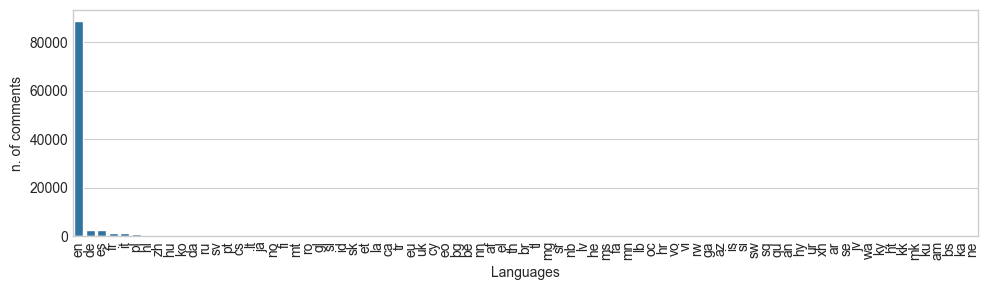

In [203]:
# Barplot of all the languages comments count
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_style("whitegrid")
fig, ax = plt.subplots(figsize=(10, 3))
sns.barplot(x=dd.index, y=dd.values, ax=ax)
ax.tick_params(axis='x', rotation=90)
ax.set_ylabel('n. of comments')
ax.set_xlabel('Languages')
plt.tight_layout()
plt.show()

# fast alternative to show a bar chart of the comment by languagaes
# df_all.Language.value_counts().plot(kind='bar')

In [204]:
# filter only comments in English
df_all = df_all[df_all['Language']=='en']
# return the number of Engligh comments
print("Number of comments in English:",df_all.Language.value_counts())

# SAVE DATA FRAME as CSV for later uses
df_all.to_csv('BGG_ALL_extracted_filtered.csv', index=False)  # do not write index columns

Number of comments in English: Language
en    88942
Name: count, dtype: int64


## 2. Aspect Identification

Reload the dataset

In [205]:
# load dataset of only reviews with English comments
df = pd.read_csv('BGG_ALL_extracted_filtered.csv', index_col=False)  
print('Dataset dimensions are: ',df.shape)
df.head(5)

Dataset dimensions are:  (88942, 4)


,Game_ID,Comment,Comment_Rating,Language
0,174430,Cons: -10/10 fiddliness -The time investment i...,NaN,en
1,174430,Excellent game. Balancing issues with some cha...,8.5,en
2,174430,PC (Epic games),NaN,en
3,174430,Best and most addictive coop game I’ve ever pl...,10.0,en
4,174430,[IMG]https://cf.geekdo-static.com/mbs/mb_17587...,5.0,en


In [206]:
# Make a copy of the dataframe
df_comments = df[['Game_ID','Comment','Comment_Rating']].copy()
df_comments.dropna(inplace = True) #remove comments without ratings
print(df_comments.shape)
df_comments.head(5)

(71320, 3)


,Game_ID,Comment,Comment_Rating
1,174430,Excellent game. Balancing issues with some cha...,8.5
3,174430,Best and most addictive coop game I’ve ever pl...,10.0
4,174430,[IMG]https://cf.geekdo-static.com/mbs/mb_17587...,5.0
5,174430,"After one play, not completing a dungeon I’m s...",7.0
6,174430,This game is a beast. So far my group has only...,9.0


In [207]:
# Define a list of the aspects that we would like to explore for similarity
aspects = ['luck','bookkeeping', 'downtime','interaction','bash the leader','complexity']
aspects = ['luck','bookkeeping', 'downtime','interaction','sacrifice','complexity'] # to be used after bash the leader similarity search

Now we will investigate 3 approaches to check which one performs better:
1. find similar words to the aspects using a pre-trained model
2. find similar words to the aspects using our dataset with comments as model
3. look at synomous directly related to our aspects

### 2.1 Find similar aspect using pre-trained model

First we notice that the concept "bash the leader" is not a specific word so we can think to search for related words (as synonyms) and then search for similar words linked to this related words

In [208]:
# Load Google's pre-trained Word2Vec model
model_pre_trained = KeyedVectors.load_word2vec_format(datapath("/Users/ZStravij/Downloads/GoogleNews-vectors-negative300.bin"),binary=True)

In [209]:
# words related to BASH THE LEADER
related_words = ['attack', 'criticize', 'blame', 'leader', 'commander','sacrifice']
similar_words_combined = []

for word in related_words:
    try:
        similar_words = model_pre_trained.most_similar(word, topn=5)  # Get top 5 for each related word
        similar_words_combined.extend(similar_words)
    except KeyError:
        print(f"Word '{word}' not found in the model.")

# Print the collected similar words
print("Words similar to the concept 'bash the leader':")
sorted(similar_words_combined,key=operator.itemgetter(1), reverse=True)[0:10]

Words similar to the concept 'bash the leader':


[('sacrifices', 0.806352972984314),
 ('attacks', 0.7638030648231506),
 ('sacrificed', 0.7461361885070801),
 ('commanding_officer', 0.7452248930931091),
 ('criticizing', 0.7426729202270508),
 ('blaming', 0.7397015690803528),
 ('Commander', 0.7284978032112122),
 ('lambast', 0.7275063395500183),
 ('lambaste', 0.7229833006858826),
 ('blamed', 0.7151628136634827)]

Next steps:
1. We decide to use word sacrifice to express the phrase bash the leader.
2. We iter the same approach to look for top 10 similar nouns related to target words
3. after getting the similar words we create a chart in 2D with this clusters

In [210]:
# Define your target words
target_words = ['luck', 'bookkeeping', 'downtime', 'interaction', 'sacrifice', 'complexity'] #"sacrifice instead of bash the leader

In [211]:
def function_aspect_detection(model_input,topnn = 10, is_model =True):
    #### function to identify similar words related to the aspects  ####
    #### input: model to be used, n° of similar words for each aspect, is_model: True or False depending on model used
    # Dictionary to store the most similar words for each target word
    similar_words_dict = {}
    # List to store all words (target words + similar words)
    all_words = []
    # List to store vectors for reduced chart TNSE
    all_vectors = []
    # For each target word, find the top 10 most similar words with different lemmas
    for word in target_words:
        print("Processing aspect ",word," -> ...")
        # Get the top 60 similar words to the aspect from the model in input
        if is_model == True:
            similar_words = model_input.most_similar(word, topn=60)
        else:
            similar_words = model_input.wv.most_similar(word, topn=60)
        noun_candidates = [] #list to store identified lemmas
        seen_lemmas = set() #set of lemmas
        for similar_word, similarity in similar_words:
            # Using spaCy for POS tagging and lemmatization
            doc = nlp(similar_word)
            for token in doc:
                # Check if the word is a noun, if it has alphabetical character, if it is not misspelled and it has a unique lemma and it is not used by other aspects
                if token.pos_ == "NOUN" and token.is_alpha == True and d.check(token.text) and token.lemma_ not in seen_lemmas and token.lemma_ not in all_words:
                    try:
                        # based on model in input two possibility to write similarity method
                        if is_model == True:
                            lemma_sim = model_input.similarity(word, token.lemma_) #measure similarity between aspect and new lemma
                        else:
                            lemma_sim = model_input.wv.similarity(word, token.lemma_) #measure similarity between aspect and new lemma
                        noun_candidates.append((token.lemma_,lemma_sim)) #append lemma to candidates and its similarity rate
                        seen_lemmas.add(token.lemma_) #add lemma to the set of lemmas
                    except KeyError:
                        print(f"Word '{token.lemma_}' not in the vocabulary of the pre-trained model.")
                        pass                
            # Stop once we reach the top `topnn` unique nouns
            if len(noun_candidates) == topnn:
                break
        #save lemmas into the dictionary
        similar_words_dict[word] = [w for w, _ in noun_candidates]
        # Add the target word and its similar words to the list to avoid duplicates of similar words for the various aspects
        all_words.append(word)  # Add target word of the aspect
        all_words.extend([w for w, _ in noun_candidates])  # Add similar word found that are referred to the aspect
        # Get the vectors for the target word and its similar words - two variant based on the type of model in input
        if is_model==True:
            all_vectors.append(model_input[word])  # Add target word vector
            all_vectors.extend([model_input[w] for w, _ in noun_candidates])  # Add vectors of similar words
        else:
            all_vectors.append(model_input.wv[word])  # Add target word vector
            all_vectors.extend([model_input.wv[w] for w, _ in noun_candidates])  # Add vectors of similar words
    return similar_words_dict, all_vectors

def plot_aspect_detected(all_vectors, target_words, similar_words_dict):
    #### Function to plot into a reduced dimensional space the similar words to the target words using TSNE
    # Convert the list of vectors to a NumPy array
    all_vectors = np.array(all_vectors)    
    # Perform dimensionality reduction using TSNE to reduce the vectors to 2D
    tsne = TSNE(n_components=2, random_state=42, perplexity=30)
    all_vectors_2d = tsne.fit_transform(all_vectors)
    # Plot the results
    plt.figure(figsize=(14, 10))
    sns.set_style("whitegrid")
    # Assign each target word and its cluster a different color
    colors = sns.color_palette("husl", len(target_words))  # A palette with enough colors for all words
    # Index to track the position to color each cluster
    start_idx = 0
    # Loop through each target word and plot its similar words
    for i, target_word in enumerate(target_words):
        # Get the similar words for the current target word
        words_for_target = [target_word] + similar_words_dict.get(target_word, [])
        # Get the corresponding 2D points from t-SNE
        points_2d = all_vectors_2d[start_idx: start_idx + len(words_for_target)]
        # Plot the points, with a different color for each target word
        plt.scatter(points_2d[:, 0], points_2d[:, 1], label=target_word, color=colors[i])
        # Annotate each point with the corresponding word
        for j, word in enumerate(words_for_target):
            plt.annotate(word, xy=(points_2d[j, 0], points_2d[j, 1]), fontsize=10)
        # Move the index for the next set of points
        start_idx += len(words_for_target)
    # Add a legend to the plot
    plt.legend()
    plt.title('t-SNE Visualization of Similar Words to Target Words')
    plt.show()

def display_dict_aspects(similar_words_dict):
    # Display similar nouns for each aspect
    for aspect, nouns in similar_words_dict.items():
        # add the aspect term as a keyword in the list of similar nouns if not present
        if aspect not in nouns:
            nouns.insert(0, aspect)
        similar_words_dict[aspect] = nouns
        print(f"\nAspect: {aspect}")
        print("Similar nouns:", nouns)

Processing aspect  luck  -> ...
Processing aspect  bookkeeping  -> ...
Processing aspect  downtime  -> ...
Processing aspect  interaction  -> ...
Processing aspect  sacrifice  -> ...
Word 'scarifie' not in the vocabulary of the pre-trained model.
Processing aspect  complexity  -> ...


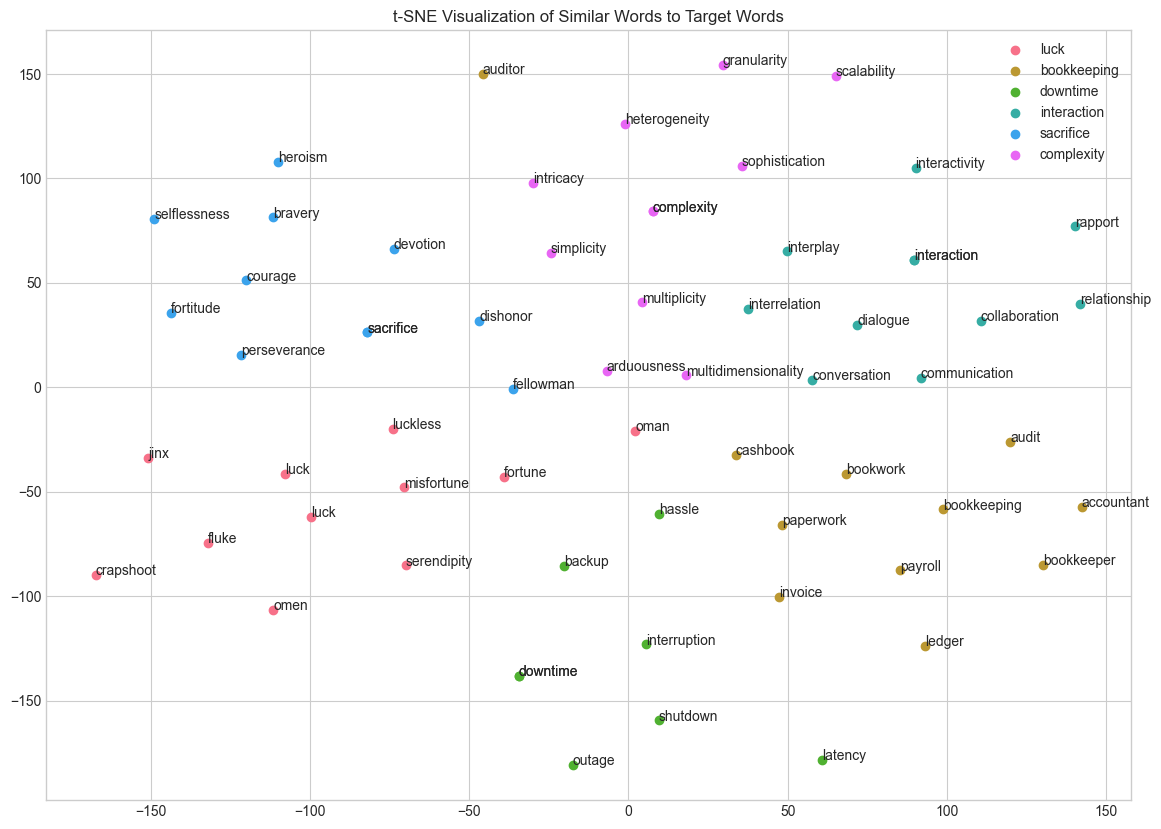


Aspect: luck
Similar nouns: ['fortune', 'serendipity', 'omen', 'luck', 'oman', 'misfortune', 'luckless', 'crapshoot', 'fluke', 'jinx']

Aspect: bookkeeping
Similar nouns: ['bookkeeping', 'bookkeeper', 'bookwork', 'payroll', 'accountant', 'audit', 'auditor', 'invoice', 'ledger', 'paperwork', 'cashbook']

Aspect: downtime
Similar nouns: ['downtime', 'interruption', 'outage', 'latency', 'backup', 'shutdown', 'hassle']

Aspect: interaction
Similar nouns: ['interaction', 'communication', 'collaboration', 'rapport', 'interactivity', 'dialogue', 'interrelation', 'conversation', 'relationship', 'interplay']

Aspect: sacrifice
Similar nouns: ['sacrifice', 'selflessness', 'fellowman', 'devotion', 'courage', 'perseverance', 'heroism', 'dishonor', 'bravery', 'fortitude']

Aspect: complexity
Similar nouns: ['complexity', 'intricacy', 'sophistication', 'heterogeneity', 'simplicity', 'multiplicity', 'multidimensionality', 'scalability', 'granularity', 'arduousness']


In [212]:
pre_train_dict, pre_train_vec = function_aspect_detection(model_pre_trained, 10)
plot_aspect_detected(pre_train_vec, target_words, pre_train_dict)
display_dict_aspects(pre_train_dict)

### 2.2 Find aspect similat using cluster from existing model of comments

Instead using a pre-trained model to search for similar nouns, we can use as model of Word2Vec the dataframe with all the comments about the boardgames.
We can therefore:
1. tokenize the comments keeping only the nouns
2. search for top 10 nouns
3. plot the cluster of these 6 groups as already done with pre-trained model

In [213]:
# Preprocessing: function to clean, tokenize text and filter only nouns
def preprocess_step(text):
    # Remove non-alphabetic characters
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    # Tokenize sentences and words
    words_token = nltk.word_tokenize(text.lower())
    # Filter only tokens that are nouns
    tags = nltk.pos_tag(words_token)
    words_token = [word for word,pos in tags if pos == 'NN']
    return words_token

# Apply preprocessing to all comments
df_comments_cluster = df_comments.copy()
df_comments_cluster['tokens'] = df_comments_cluster['Comment'].apply(preprocess_step)
df_comments_cluster.head(2)

,Game_ID,Comment,Comment_Rating,tokens
1,174430,Excellent game. Balancing issues with some cha...,8.5,"[game, end, game, player, game, epic, game, play]"
3,174430,Best and most addictive coop game I’ve ever pl...,10.0,"[coop, game, etc, time, party]"


Processing aspect  luck  -> ...
Processing aspect  bookkeeping  -> ...
Processing aspect  downtime  -> ...
Processing aspect  interaction  -> ...
Processing aspect  sacrifice  -> ...
Processing aspect  complexity  -> ...


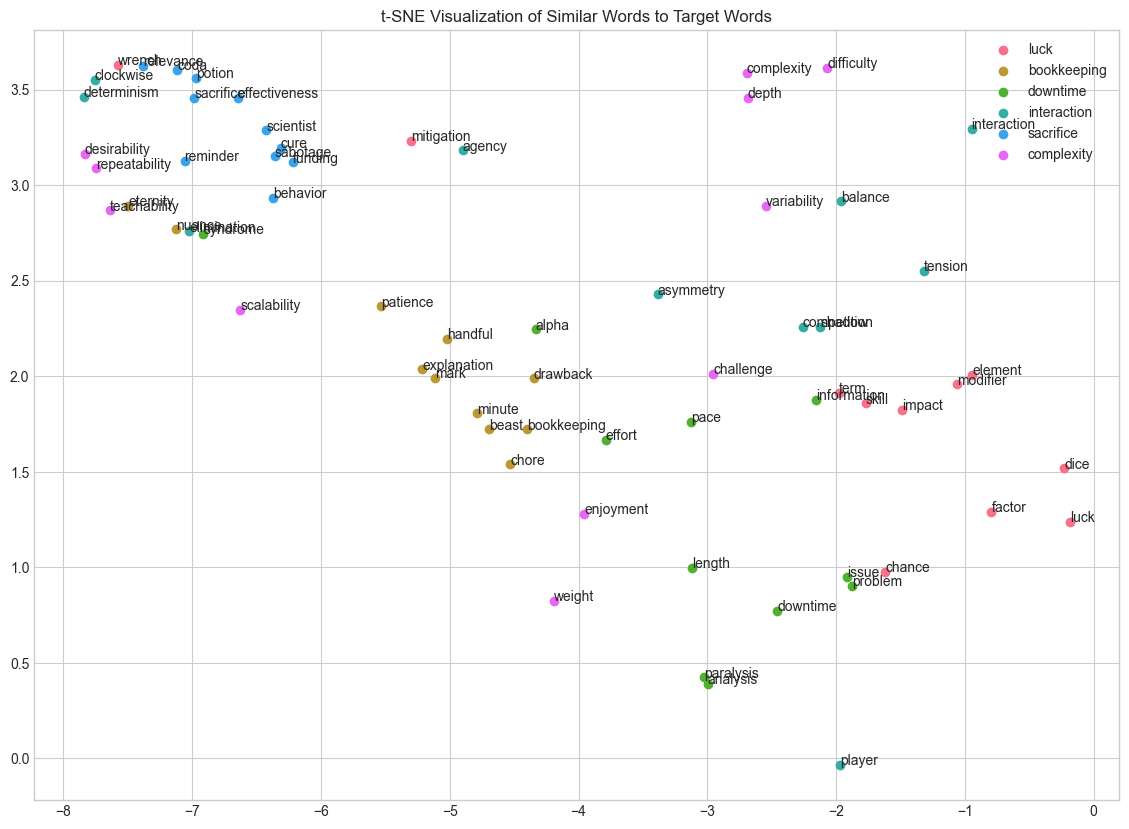


Aspect: luck
Similar nouns: ['luck', 'factor', 'dice', 'impact', 'skill', 'term', 'mitigation', 'modifier', 'element', 'wrench', 'chance']

Aspect: bookkeeping
Similar nouns: ['bookkeeping', 'chore', 'drawback', 'eternity', 'minute', 'explanation', 'beast', 'nuance', 'patience', 'handful', 'mark']

Aspect: downtime
Similar nouns: ['downtime', 'paralysis', 'problem', 'alpha', 'pace', 'information', 'analysis', 'issue', 'length', 'syndrome', 'effort']

Aspect: interaction
Similar nouns: ['interaction', 'elimination', 'competition', 'player', 'shadow', 'tension', 'determinism', 'agency', 'balance', 'clockwise', 'asymmetry']

Aspect: sacrifice
Similar nouns: ['sacrifice', 'cure', 'scientist', 'potion', 'behavior', 'sabotage', 'funding', 'effectiveness', 'coda', 'reminder', 'relevance']

Aspect: complexity
Similar nouns: ['complexity', 'depth', 'variability', 'desirability', 'scalability', 'weight', 'repeatability', 'difficulty', 'enjoyment', 'teachability', 'challenge']


In [214]:
# Train a Word2Vec model on the tokenized comments
model_rev_trained = Word2Vec(sentences=df_comments_cluster['tokens'], vector_size=100, window=5, min_count=1, workers=4)

# using model trained on user reviews
rev_train_dict,rev_train_vec = function_aspect_detection(model_rev_trained, 10, is_model=False)
plot_aspect_detected(rev_train_vec, target_words, rev_train_dict)
display_dict_aspects(rev_train_dict)

### 2.3 Set aspects using a rule based dictionary

In [215]:
# Aspects and their keywords
aspect_keywords = {
    'luck': ['luck', 'random', 'chance', 'fortune', 'unpredictable', 'dice', 'out of control'],
    'bookkeeping': ['bookkeeping', 'recording', 'log', 'reference', 'rulebook', 'manual', 'check the rules'],
    'downtime': ['downtime', 'waiting', 'bored', 'idle', 'nothing to do', 'time between turns'],
    'interaction': ['interaction', 'engagement', 'influence', 'cooperation', 'competitive', 'opponent'],
    'bash_the_leader': ['bash the leader', 'ganging up', 'sacrifice', 'prevent victory', 'stop the leader'],
    'complexity': ['complex', 'depth', 'strategy', 'complicated', 'rules-heavy', 'nuances']
}

## 3. Method 1: Aspect extraction & Sentiment Classification

#### 3.1 Aspect extraction
For the 3 type of dictionaries that were build before we can extract words from comments, but we can decide to perform this steps just on 2 of them.
This steps is quite simple:
- analyze the comment field
- store into a new columns a dictionary with {aspect: "sentence"} in quick the target words are found

In [221]:
# Apply preprocessing to all comments
df_comments_1_pre = df_comments.copy()
df_comments_2_mod = df_comments.copy()
# df_comments_3_rul = df_comments.copy()

In [217]:
# Function to get the aspects extracted from the comments

# Define function to tokenize sentences
def tokenize_sentences(text):
    return nltk.sent_tokenize(text)

# Function to check for keyword matches in the sentences
def keyword_aspect_extraction(text, aspect_list):
    aspects_found = defaultdict(list)
    sentences = tokenize_sentences(text)
    # iter into sentences and search for aspects_target
    for sentence in sentences:
        for aspect, keywords in aspect_list.items():
            if any(keyword.lower() in sentence.lower() for keyword in keywords):
                aspects_found[aspect].append(sentence)
    return dict(aspects_found)

1. Application on 1st dictionary

In [218]:
# Apply aspect extraction on each comment on the 1st model
df_comments_1_pre['Aspects_Extracted'] = df_comments_1_pre['Comment'].apply(lambda x: keyword_aspect_extraction(x, pre_train_dict))
print("Initial dataset dimension",df_comments_1_pre.shape)
# Apply filter to keep only extracted aspects
df_filtered_1 = df_comments_1_pre[df_comments_1_pre['Aspects_Extracted'].apply(lambda x: any(len(v) > 0 for v in x.values()))]
print("Dimension after applying the filter:", df_filtered_1.shape)
df_filtered_1.head(5)

Initial dataset dimension (71320, 4)
Dimension after applying the filter: (7632, 4)


,Game_ID,Comment,Comment_Rating,Aspects_Extracted
13,174430,Extremely well designed game. All classes are ...,9.0,"{'luck': ['Missions often lead to ""edge-of-you..."
16,174430,Imagine if D&D's dungeon crawling and role-pla...,10.0,"{'interaction': ['Insane amounts of content, i..."
17,174430,"Very mechanical, abstract and repetitive, and ...",5.0,{'interaction': ['I strongly dislike the limit...
54,174430,My limited interactions with Gloomhaven left m...,5.0,{'interaction': ['My limited interactions with...
64,174430,Gloomhaven is NOT for the casual gamer. I woul...,8.0,"{'luck': ['You WILL feel pain and suffering, t..."


In [249]:
# Example of how the columns Aspects_Extracted looks like
df_filtered_1.iloc[6,3]

{'luck': ['It happened quite a few times that either an enemy asspulled 2x DMG, or you failed to land a hit in crucial moments and you ended up dead, luck mitigation is non existent and frustrating.']}

2. Application on 2nd dictionary

In [222]:
# Apply aspect extraction on each comment on the 2nd model
df_comments_2_mod['Aspects_Extracted'] = df_comments_2_mod['Comment'].apply(lambda x: keyword_aspect_extraction(x, rev_train_dict))
print("Initial dataset dimension of dataset",df_comments_2_mod.shape)
# Apply filter to keep only extracted aspects
df_filtered_2 = df_comments_2_mod[df_comments_2_mod['Aspects_Extracted'].apply(lambda x: any(len(v) > 0 for v in x.values()))]
print("Dimension after applying the filfer of only rows with columns", df_filtered_2.shape)
df_filtered_2.head(5)

Initial dataset dimension of dataset (71320, 4)
Dimension after applying the filfer of only rows with columns (25337, 4)


,Game_ID,Comment,Comment_Rating,Aspects_Extracted
1,174430,Excellent game. Balancing issues with some cha...,8.5,{'downtime': ['Balancing issues with some char...
6,174430,This game is a beast. So far my group has only...,9.0,"{'bookkeeping': ['This game is a beast.', 'So ..."
10,174430,I kickstarted the 1st edition of Gloomhaven bu...,5.0,{'bookkeeping': ['The cardboard terrain is dou...
12,174430,Gloomhaven is sold as D&D but better. It's not...,1.0,"{'downtime': ['No role playing, no creative pr..."
13,174430,Extremely well designed game. All classes are ...,9.0,"{'interaction': ['All classes are fun to play,..."


In [223]:
# How the columns Aspects_Extracted looks like
df_filtered_2.iloc[6,3]

{'interaction': ["Very mechanical, abstract and repetitive, and I wouldn't call it particularly thematic (the strength surely lies in the player card mechanisms), but intriguing nonetheless, as an optimization puzzle."],
 'downtime': ['With each play so far, the game feels more and more like an abstract, mechanical, repetitive challenge with a clever system where a few components (your hand of cards) can be combined in multiple ways for many potential solutions, and it feels like the thematic and narrative efforts are just silly.'],
 'complexity': ['With each play so far, the game feels more and more like an abstract, mechanical, repetitive challenge with a clever system where a few components (your hand of cards) can be combined in multiple ways for many potential solutions, and it feels like the thematic and narrative efforts are just silly.']}

#### 3.2 Sentiment classification

Perform sentiment classification using TextBlob library that analyzes the sentences referred to the aspect and gives a polarity rate for each of them into a new colums, storing the result into a dictionary

In [228]:
# Function to extract sentiment for each aspect-related sentence
def extract_sentiment(sentences):
    sentiments = []
    for sentence in sentences:
        blob = TextBlob(sentence)
        sentiment = blob.sentiment.polarity
        if sentiment > 0.05:
            sentiments.append('positive')
        elif sentiment < -0.05:
            sentiments.append('negative')
        else:
            sentiments.append('neutral')
    return sentiments

# Apply sentiment analysis to extracted aspects
def aspect_sentiment_analysis(df):
    df['Aspect_Sentiments'] = df['Aspects_Extracted'].apply(lambda aspects: {aspect: extract_sentiment(sentences) for aspect, sentences in aspects.items()})
    return df

In [229]:
# Apply aspect sentiment analysis
df_filtered_1 = aspect_sentiment_analysis(df_filtered_1)
# Display one example
print(df_filtered_1.iloc[4,4])
# Display results of the output df
df_filtered_1.head(5)

{'luck': ['negative', 'negative', 'positive']}


,Game_ID,Comment,Comment_Rating,Aspects_Extracted,Aspect_Sentiments
13,174430,Extremely well designed game. All classes are ...,9.0,"{'luck': ['Missions often lead to ""edge-of-you...",{'luck': ['positive']}
16,174430,Imagine if D&D's dungeon crawling and role-pla...,10.0,"{'interaction': ['Insane amounts of content, i...",{'interaction': ['negative']}
17,174430,"Very mechanical, abstract and repetitive, and ...",5.0,{'interaction': ['I strongly dislike the limit...,{'interaction': ['positive']}
54,174430,My limited interactions with Gloomhaven left m...,5.0,{'interaction': ['My limited interactions with...,{'interaction': ['positive']}
64,174430,Gloomhaven is NOT for the casual gamer. I woul...,8.0,"{'luck': ['You WILL feel pain and suffering, t...","{'luck': ['negative', 'negative', 'positive']}"


Display the analyzed sentiment of the games for both models 1 and 2 with their specific aspects.

In [230]:
# Function to filter by game_id and count sentiment occurrences for all aspects
def filter_sentiments_by_game(df, col_name, game_id=None):
    if game_id==None:
        filtered_df = df    
    else:
        filtered_df = df[df['Game_ID'] == game_id]  # Filter by game_id
    sentiment_counts = defaultdict(lambda: defaultdict(int))
    for _, row in filtered_df.iterrows():
        for aspect, sentiments in row[col_name].items():
            for sentiment in sentiments:
                sentiment_counts[aspect][sentiment] += 1
    return sentiment_counts

# Convert the sentiment counts to long-form DataFrame for FacetGrid
def prepare_long_form_df(sentiment_counts):
    data = []    
    for aspect, sentiments in sentiment_counts.items():
        for sentiment, count in sentiments.items():
            data.append({
                'Aspect': aspect,
                'Sentiment': sentiment,
                'Count': count
            })
    return pd.DataFrame(data)

# Function to create FacetGrid plot
def plot_facetgrid_sentiments(df, col_name, game_id=None):
    # Step 1: Get sentiment counts for all aspects for the given game_id
    sentiment_counts = filter_sentiments_by_game_mod(df, col_name, game_id)
    # Step 2: Prepare the long-form DataFrame for Seaborn
    long_df = prepare_long_form_df(sentiment_counts)
    print(long_df)
    # Step 3: Create a FacetGrid to plot sentiment distribution per aspect
    g = sns.FacetGrid(long_df, col="Aspect", col_wrap=3, height=4, aspect=1.5)
    g.map(sns.barplot, "Sentiment", "Count", palette="viridis",order=long_df.Sentiment.unique())
    g.add_legend()
    # Adjust plot titles and labels
    g.set_titles("{col_name}")
    g.set_axis_labels("Sentiment", "Count")
    for ax in g.axes:
        for p in ax.patches:
                 ax.annotate("%.0f" % p.get_height(), (p.get_x() + p.get_width() / 2., p.get_height()),
                     ha='center', va='center', fontsize=11, color='black', xytext=(0, 5),
                     textcoords='offset points')
    # Show the plot
    plt.tight_layout()
    plt.show()

         Aspect Sentiment  Count
0    complexity  positive    172
1    complexity  negative     95
2    complexity   neutral    101
3          luck  positive    116
4          luck   neutral     49
5          luck  negative     39
6   interaction  positive    107
7   interaction   neutral     45
8   interaction  negative     38
9   bookkeeping  negative      7
10  bookkeeping  positive     10
11  bookkeeping   neutral      5
12    sacrifice  positive     18
13    sacrifice   neutral      4
14    sacrifice  negative      7
15     downtime  negative     11
16     downtime  positive     12
17     downtime   neutral     12


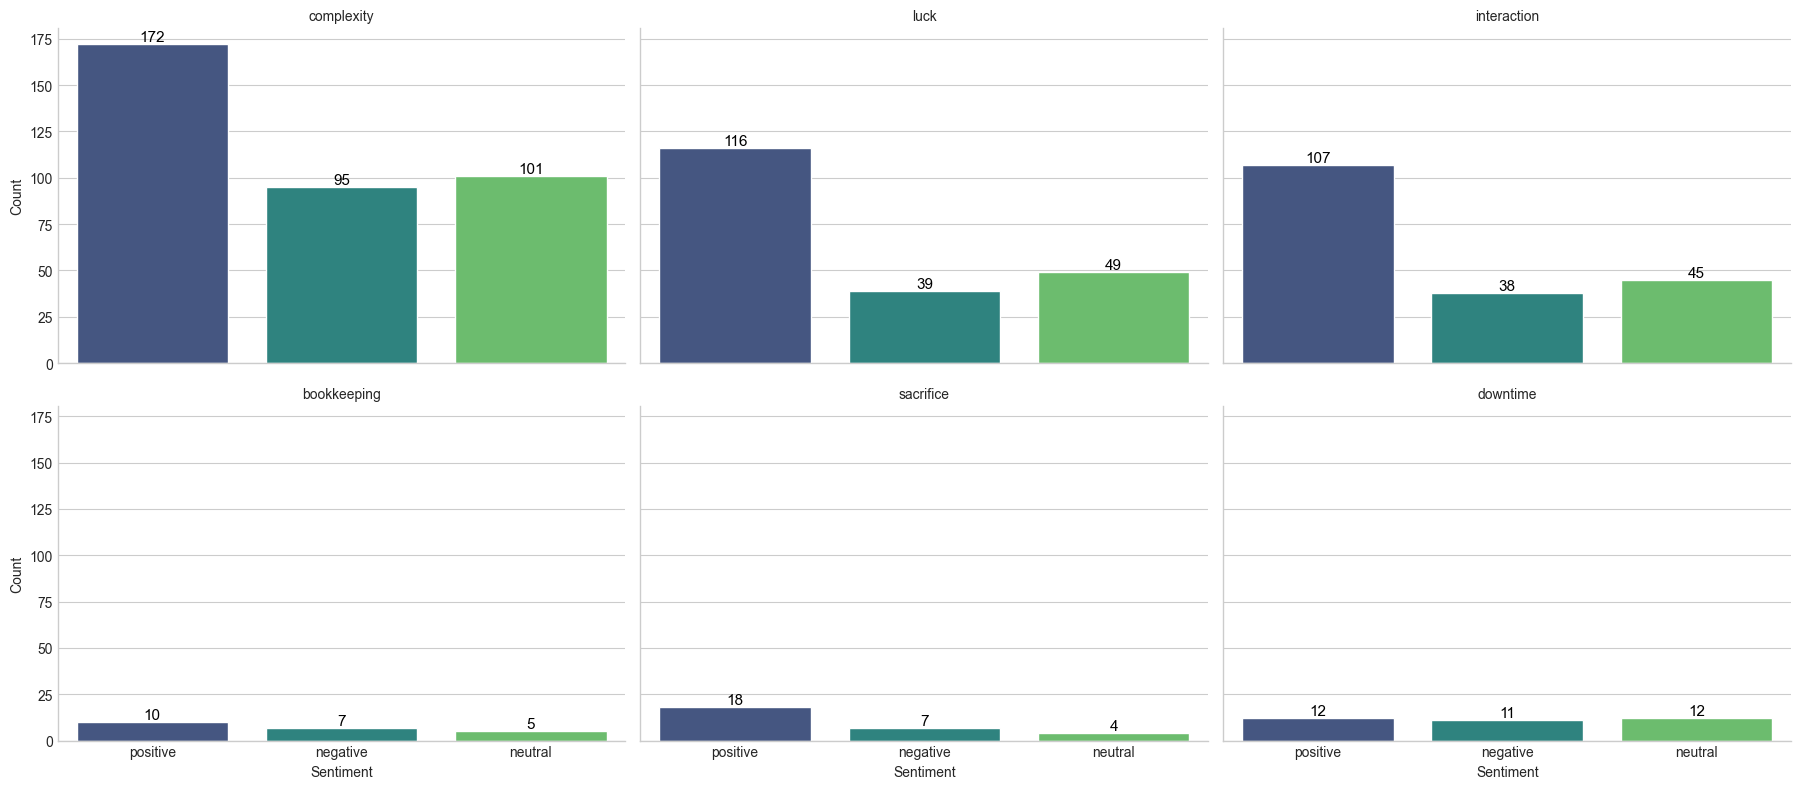

In [231]:
game_id_to_filter = 162886 # Example game ID (others 174430,...)
# Apply the FacetGrid plotting function
plot_facetgrid_sentiments(df_filtered_1, 'Aspect_Sentiments', game_id_to_filter)

         Aspect Sentiment  Count
0   interaction  positive   1106
1   interaction  negative    432
2   interaction   neutral    454
3    complexity  positive    767
4    complexity   neutral    346
5    complexity  negative    329
6      downtime  negative    206
7      downtime   neutral    211
8      downtime  positive    345
9   bookkeeping  positive    123
10  bookkeeping  negative     57
11  bookkeeping   neutral     52
12         luck  positive    261
13         luck   neutral    130
14         luck  negative    123
15    sacrifice  positive     17
16    sacrifice  negative      7
17    sacrifice   neutral      6


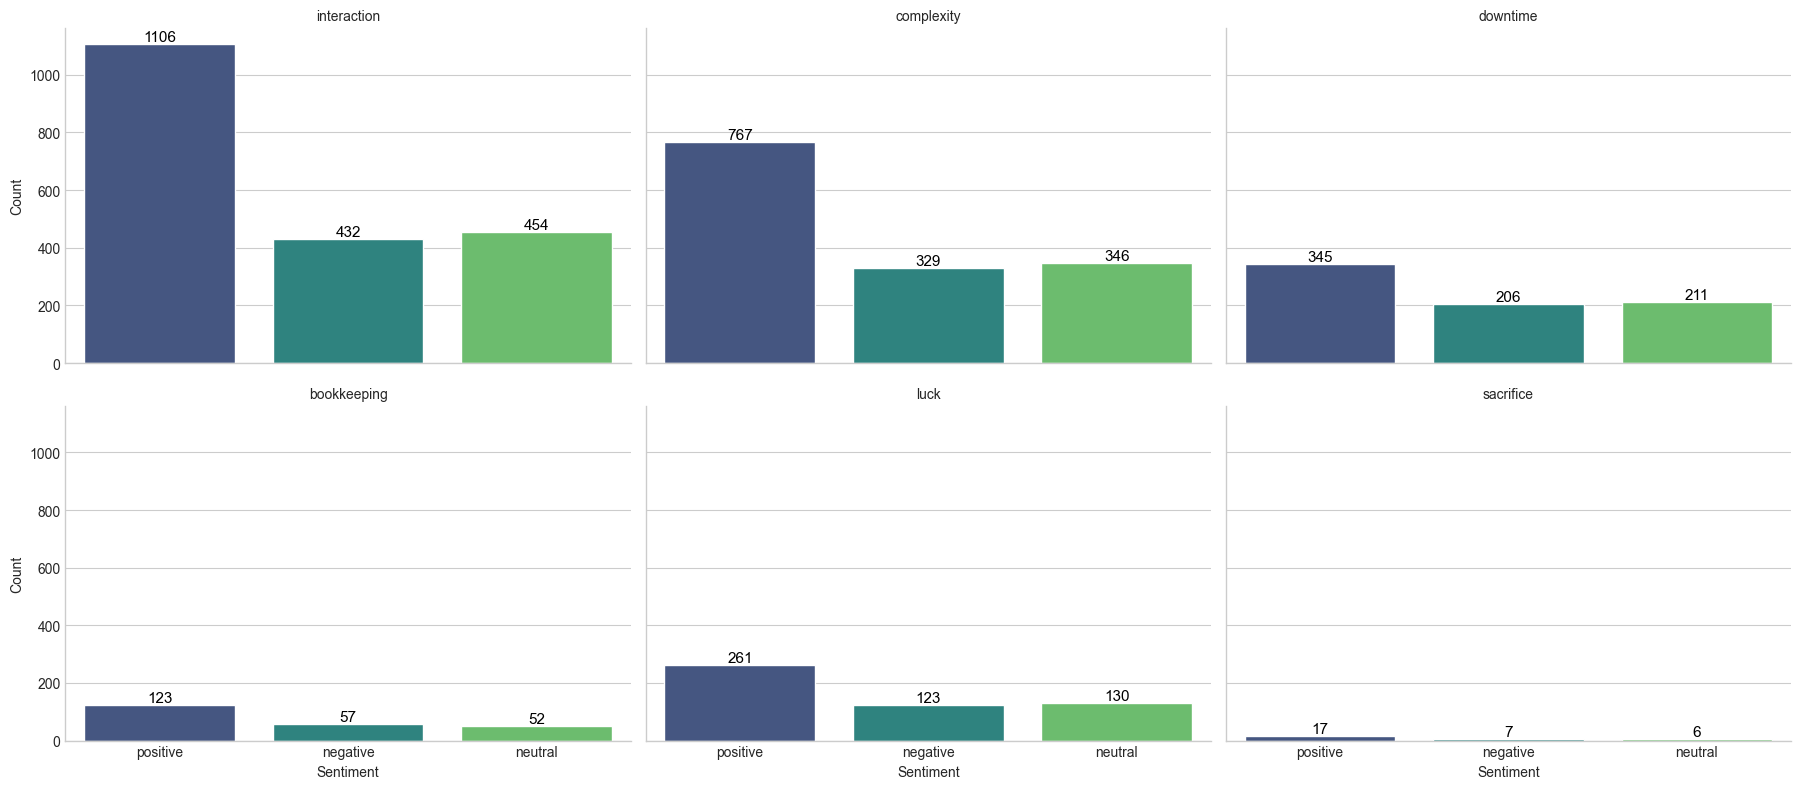

In [233]:
# Apply aspect sentiment analysis - 2nd model
df_filtered_2 = aspect_sentiment_analysis(df_filtered_2)
# Apply the FacetGrid plotting function
plot_facetgrid_sentiments(df_filtered_2, 'Aspect_Sentiments',game_id_to_filter)

We can look at some of this example to check how the algorithm process the outputs

In [245]:
# analyze output results
sample_index = 0  # Change this to see different comments
sample_comment = df_filtered_1.iloc[sample_index]
# Display comments , etc.
print("Original Comment:")
print(sample_comment['Comment'])
print("\nRating:")
print(sample_comment['Comment_Rating'])
print("\nAspects Extracted:")
print(sample_comment['Aspects_Extracted'])
print("\nAspect Sentiments:")
for aspect, sentiment in sample_comment['Aspect_Sentiments'].items():
    print(f"Aspect: {aspect}, Sentiment: {sentiment}")

Original Comment:
Extremely well designed game. All classes are fun to play, and seemingly well balanced. Missions often lead to "edge-of-your-seat" moments, where one or two cards can determine the difference between success or failure (or perhaps it is just my group that suck :)). Highly recommended!

Rating:
9.0

Aspects Extracted:
{'luck': ['Missions often lead to "edge-of-your-seat" moments, where one or two cards can determine the difference between success or failure (or perhaps it is just my group that suck :)).']}

Aspect Sentiments:
Aspect: luck, Sentiment: ['positive']


In [246]:
# analyze output results
sample_index = 4  # Change this to see different comments
sample_comment = df_filtered_2.iloc[sample_index]
# Display comments , etc.
print("Original Comment:")
print(sample_comment['Comment'])
print("\nRating:")
print(sample_comment['Comment_Rating'])
print("\nAspects Extracted:")
print(sample_comment['Aspects_Extracted'])
print("\nAspect Sentiments:")
for aspect, sentiment in sample_comment['Aspect_Sentiments'].items():
    print(f"Aspect: {aspect}, Sentiment: {sentiment}")

Original Comment:
Extremely well designed game. All classes are fun to play, and seemingly well balanced. Missions often lead to "edge-of-your-seat" moments, where one or two cards can determine the difference between success or failure (or perhaps it is just my group that suck :)). Highly recommended!

Rating:
9.0

Aspects Extracted:
{'interaction': ['All classes are fun to play, and seemingly well balanced.'], 'luck': ['Missions often lead to "edge-of-your-seat" moments, where one or two cards can determine the difference between success or failure (or perhaps it is just my group that suck :)).']}

Aspect Sentiments:
Aspect: interaction, Sentiment: ['positive']
Aspect: luck, Sentiment: ['positive']


## 4. Methods 2: Aspect extraction & Sentiment Classification

This second methods uses the dependency parsing to get:
- adject dependency to nouns
- nouns + verb + adj dependecies

with regards to our target aspects related to aspects

In [247]:
# Example: parse the text and visualize the dependency structure
review = df_filtered_1['Comment'].values
doc = nlp(review[8])
for token in doc:
    print(f"{token.text} -> {token.dep_} -> {token.head.text}")

Takes -> advcl -> is
too -> advmod -> long
long -> advmod -> Takes
to -> aux -> set
set -> xcomp -> Takes
up -> prt -> set
, -> punct -> is
bookkeeping -> nsubj -> is
is -> ROOT -> is
a -> det -> hassle
hassle -> attr -> is
. -> punct -> is
That -> det -> RPG
aside -> advmod -> RPG
, -> punct -> RPG
a -> det -> RPG
great -> amod -> table
table -> nmod -> RPG
top -> amod -> RPG
RPG -> ROOT -> RPG


In [248]:
#dependency parse for noun phrase can be seen as a dataframe
components = []
for chunk in doc.noun_chunks:
    components.append({
        'text': chunk.text, 'root': chunk.root.text, 'root_dep': chunk.root.dep_, 
        'root_head': chunk.root.head.text
    })
pd.DataFrame(components)

,text,root,root_dep,root_head
0,bookkeeping,bookkeeping,nsubj,is
1,a hassle,hassle,attr,is
2,"That aside, a great table top RPG",RPG,ROOT,RPG


#### 4.1 Aspect extraction (with adaptation from course main functions)

Explore the pattern dependency with adjectived and verbs related to target words. 

This steps starts from available function of the Text Mining and Sentiment Analysis course, that are tuned somehow for the specific purpose of this project.

In [251]:
def spacy_sentences(nlp, text):
    #### function to split text in input into sentences ####
    sentences = []
    for sent in nlp(text).sents:
        sentences.append(sent)
    return sentences

def explore(token, children=None, level=0, order=None):
    #### function to get children related to a specific token given in input ####
    if children is None:
        children = []
    if order is None:
        order = token.idx
    for child in token.children:
        children.append((child, level, child.idx < order))
        explore(child, children=children, level=level+1, order=order)
    return children

def search_adjectives(nlp_text, target_list_words, nouns=None):
    #### function to map adjectived to nouns ####
    # prepare a mapping dictionary of nouns and related adjectives
    nouns_map = dict([(x, []) for x in nlp_text if x.pos_ in ['NOUN', 'PROPN'] if x.lemma_ in target_list_words]) 
    if nouns is None:
        nouns = nouns_map.keys()
    else:
        pass
    for noun in nouns:
        subtree = explore(noun)
        subnouns = [(x, l) for x, l, _ in subtree if x.pos_ in ['NOUN', 'PROPN']]
        for token, level, left in subtree:
            if token.pos_ == 'ADJ' and len([(n, l) for n, l in subnouns if l < level]) == 0:
                # Check for negation in adjective's children
                negated = any(child.dep_ == 'neg' for child in token.children) or \
                          any(parent.dep_ == 'neg' for parent in token.head.children if parent != token)
                try:
                    # item in mapping dictionary is a tuple that tells if an adjective if it is negated ot not in the sentence
                    nouns_map[noun].append((token, "negated" if negated else "positive"))
                except KeyError:
                    pass
    return nouns_map

def verb_adjectives(text, adjective_map, target_words, be_only=True):
    #### function to search for verb patterns: noun -> verb -> adjective ####
    if be_only:
        verbs = [x for x in text if x.lemma_ == 'be']
    else:
        verbs = [x for x in text if x.pos_ in {'AUX', 'VERB'}]
    # iteration on all verbs in the text
    for verb in verbs:
        subtokens = explore(verb)
        subject = [(x) for x, level, left in subtokens if left and x.dep_ == 'nsubj']
        if len(subject) > 0:
            subj = subject[0]
            for candidate, level, left in subtokens:
                if not left:
                    if candidate.pos_ == 'ADJ' and level == 0:
                        # Check for possible negation in the childern
                        negated = any(child.dep_ == 'neg' for child in candidate.children) or \
                                  any(parent.dep_ == 'neg' for parent in candidate.head.children if parent != candidate)
                        try:
                            # update the adjective mapping function with possible negation or not
                            adjective_map[subj].append((candidate, "negated" if negated else "positive")) 
                        except KeyError:
                            pass
                    elif candidate.dep_ in ['dobj', 'attr', 'conj']:
                        adj = search_adjectives(text, target_words, nouns=[candidate])
                        try:
                            adjective_map[subj] += adj[candidate]
                        except KeyError:
                            pass                        
                    else:
                        pass

def combine_adjectives_verbs_search(input_text, input_train_dict):
    #### function that combines adjective and verb search patterns ####
    # list to store mapping of adjectives
    adj_map = []
    # create list of target words and flatten it
    list_words  = [item for kk, item in input_train_dict.items()]
    flat_list_words = [item for row in list_words for item in row] #flatten the list
    # analyze comment input with spacy separating it into sentences
    sample = spacy_sentences(nlp, input_text)
    # iterative search of adj and verb pattern for each sentence of the user comment
    for s in sample:
        adj_map_s = search_adjectives(s, flat_list_words)
        verb_adjectives(s, adj_map_s, flat_list_words)
        adj_map.append(adj_map_s)
    # dictionary of mapping
    combined_map = {k: v for d in adj_map for k, v in d.items()}
    return combined_map

We test this methods using:
1. a simplified version of the dataset filtere for only one game as example 
2. having in input the 2nd dictionary of target words

The first step is to retrieve the adjectives related to the target words and if they have a positive or negative (due to negation "not") status in the sentences.

In [252]:
# Prepare the simpliefied version of the dataset
df_2_2 = df_comments.copy()
df_2_2 = df_2_2[df_2_2['Game_ID']==game_id_to_filter]
# Apply Dependency parsing to get adjective linked to target aspects and their positive or negates status
df_2_2 ['Dependency_Aspect_Status'] = df_2_2.apply(lambda row: combine_adjectives_verbs_search(row['Comment'], rev_train_dict), axis=1)
# Filter the DataFrame to keep only rows that have not an empty list in the column
df_2_2  = df_2_2 [df_2_2 ['Dependency_Aspect_Status'].apply(lambda x: len(x) > 0)]
df_2_2 

,Game_ID,Comment,Comment_Rating,Dependency_Aspect_Status
81569,162886,"All aboard the hype train! Ding ding! No, but ...",9.0,"{asymmetry: [], complexity: [], players: [], v..."
81570,162886,"Good. There are so many things to do at once, ...",8.0,"{player: [(single, 'positive')]}"
81571,162886,"Challenging, thinky game with clever mechanism...",5.0,"{challenge: [(cooperative, 'positive')], playe..."
81572,162886,Excellent heavy cooperative game with variable...,10.0,"{player: [(variable, 'positive')], complexity:..."
81579,162886,"Lovely, unique theme. Components if not outsta...",10.0,{difficulty: []}
...,...,...,...,...
88927,162886,I think this is my new favourite game. I love ...,10.0,"{player: [], problem: [], luck: []}"
88928,162886,My ability to play higher weight games appears...,8.0,{weight: []}
88933,162886,"Every game is different from the previous one,...",10.0,{difficulty: []}
88935,162886,Apparently I really love horror co-op games. T...,9.0,"{difficulty: [(easy, 'positive')]}"


#### 4.2 Sentiment classification
Secondly we perform the polarity search using VADER analyzer

In [253]:
# Initialize the VADER sentiment analyzer
analyzer = SentimentIntensityAnalyzer()

To compute polarity of the aspects we proceed with 2 steps:
1. retrieve the sentiment score of the adjectives using VADER analyzer (score and evaluation [positive, neutral, negative])
2. aggregate the scores to the aspects

In [254]:
def sentiment_dependency(adj_map):
    # function to link a score to each adjective of the nouns detected in previous step
    aspect_scores = {}
    for aspect, adjs in adj_map.items():
        total_score = 0
        if len(adjs) ==0:
            pass
        else:
            for ii in adjs:
                x,state = str(ii[0]),str(ii[1])
                sentiment_score = analyzer.polarity_scores(str(x))
                # use the compound score of VADER
                compound_score = sentiment_score['compound']
                if state == 'negated':
                    compound_score = -compound_score
                total_score += compound_score
            if total_score >= 0.05:
                polarity = 'positive'
            elif compound_score <= -0.05:
                polarity = 'negative'
            else:
                polarity = 'neutral'
            aspect_scores[aspect]=(total_score,polarity)
    return aspect_scores

In [271]:
# 1st step -> get scores of adjectives
# use try / expect to check errors in function -> SOLVED
try:
    df_2_2['Sentiment_Dependence'] = df_2_2.apply(lambda row: sentiment_dependency(row['Dependency_Aspect_Status']), axis=1)
except KeyError as e:
    print(f"KeyError: {e}")
except Exception as e:
    print(f"An error occurred: {e}")
# filter rows with not empty values in the column
df_2_2 = df_2_2[df_2_2['Sentiment_Dependence'].apply(lambda x: len(x) > 0)]
df_2_2.head()

,Game_ID,Comment,Comment_Rating,Dependency_Aspect_Status,Sentiment_Dependence
81570,162886,"Good. There are so many things to do at once, ...",8.0,"{player: [(single, 'positive')]}","{player: (0.0, 'neutral')}"
81571,162886,"Challenging, thinky game with clever mechanism...",5.0,"{challenge: [(cooperative, 'positive')], playe...","{challenge: (0.0, 'neutral'), players: (0.0, '..."
81572,162886,Excellent heavy cooperative game with variable...,10.0,"{player: [(variable, 'positive')], complexity:...","{player: (0.0, 'neutral')}"
81586,162886,Positives: Brain burner (in a good way) Luck...,10.0,"{players: [(more, 'positive')], player: [(high...","{players: (0.0, 'neutral'), player: (0.0, 'neu..."
81591,162886,"This is the best co-op game I've ever played, ...",10.0,"{interaction: [(great, 'positive')]}","{interaction: (0.6249, 'positive')}"


In [281]:
# 2nd step -> aggregate the scores to the target aspects
def aggregate_to_aspect(score_dict,dict_aspects):
    #### Function to classify sentiments of the aspects, takes in input the score dictionary and the target aspects ####
    # dictionary to store the sentiments of the aspects
    result = {}
    # translate score dictionary with lemma keywords because otherwise the dictionaries keyword do not match
    new_dict = {" ".join([token.lemma_ for token in nlp(str(key))]):value for key, value in score_dict.items()}
    # create a list with all target aspects
    search_list = [x for x in new_dict.keys()]
    # print("0 level:", dict_aspects.keys())
    for key_level, items in dict_aspects.items():
        # print("1 lev:",key_level)
        total_value=0
        is_found=False
        for key in items:
            # print(" 2 lev:", key)
            if key in search_list:
                # print("  3 lev:", key," -> ",new_dict[key][0]," / ",new_dict[key][1])
                total_value += new_dict[key][0]
                is_found = True
        # Classify the summed value and assign to the result dictionary
        if is_found == True:
            result[key_level] = [classify(total_value)]
    return result

def classify(value):
        if value > 0.05: #0.05
            return 'positive'
        elif value < -0.05:#-0.05:
            return 'negative'
        else:
            return 'neutral'

In [282]:
# try/error to check errors in the functions -> SOLVED
try:
    df_2_2['Sentiment_Score'] = df_2_2.apply(lambda row: aggregate_to_aspect(row['Sentiment_Dependence'],rev_train_dict), axis=1)
except KeyError as e:
    print(f"KeyError: {e}")
except Exception as e:
    print(f"An error occurred: {e}")
df_2_2

,Game_ID,Comment,Comment_Rating,Dependency_Aspect_Status,Sentiment_Dependence,Sentiment_Score
81570,162886,"Good. There are so many things to do at once, ...",8.0,"{player: [(single, 'positive')]}","{player: (0.0, 'neutral')}",{'interaction': ['neutral']}
81571,162886,"Challenging, thinky game with clever mechanism...",5.0,"{challenge: [(cooperative, 'positive')], playe...","{challenge: (0.0, 'neutral'), players: (0.0, '...","{'interaction': ['neutral'], 'complexity': ['p..."
81572,162886,Excellent heavy cooperative game with variable...,10.0,"{player: [(variable, 'positive')], complexity:...","{player: (0.0, 'neutral')}",{'interaction': ['neutral']}
81586,162886,Positives: Brain burner (in a good way) Luck...,10.0,"{players: [(more, 'positive')], player: [(high...","{players: (0.0, 'neutral'), player: (0.0, 'neu...",{'interaction': ['neutral']}
81591,162886,"This is the best co-op game I've ever played, ...",10.0,"{interaction: [(great, 'positive')]}","{interaction: (0.6249, 'positive')}",{'interaction': ['positive']}
...,...,...,...,...,...,...
88877,162886,Amazing solo/cooperative 'puzzle'. Game loop i...,9.8,"{element: [], challenge: [(tougher, 'positive')]}","{challenge: (0.1779, 'positive')}",{'complexity': ['positive']}
88908,162886,This game is fantastic. I tend to like games w...,10.0,"{players: [(other, 'positive')]}","{players: (0.0, 'neutral')}",{'interaction': ['neutral']}
88913,162886,My rating for this game is for the really soli...,7.0,"{players: [(more, 'positive')]}","{players: (0.0, 'neutral')}",{'interaction': ['neutral']}
88920,162886,Deserves hype for one of the best coop games. ...,9.0,"{interaction: [(possible, 'positive')], player...","{interaction: (0.0, 'neutral'), player: (0.0, ...","{'downtime': ['neutral'], 'interaction': ['neu..."


Display barplot of polarities referred to the aspects.

         Aspect Sentiment  Count
0   interaction   neutral    415
1   interaction  positive     87
2   interaction  negative     12
3    complexity  positive     95
4    complexity   neutral    313
5    complexity  negative     36
6          luck   neutral    100
7          luck  negative     11
8          luck  positive     22
9      downtime   neutral    110
10     downtime  negative     12
11     downtime  positive     18
12  bookkeeping   neutral     19
13  bookkeeping  positive      5


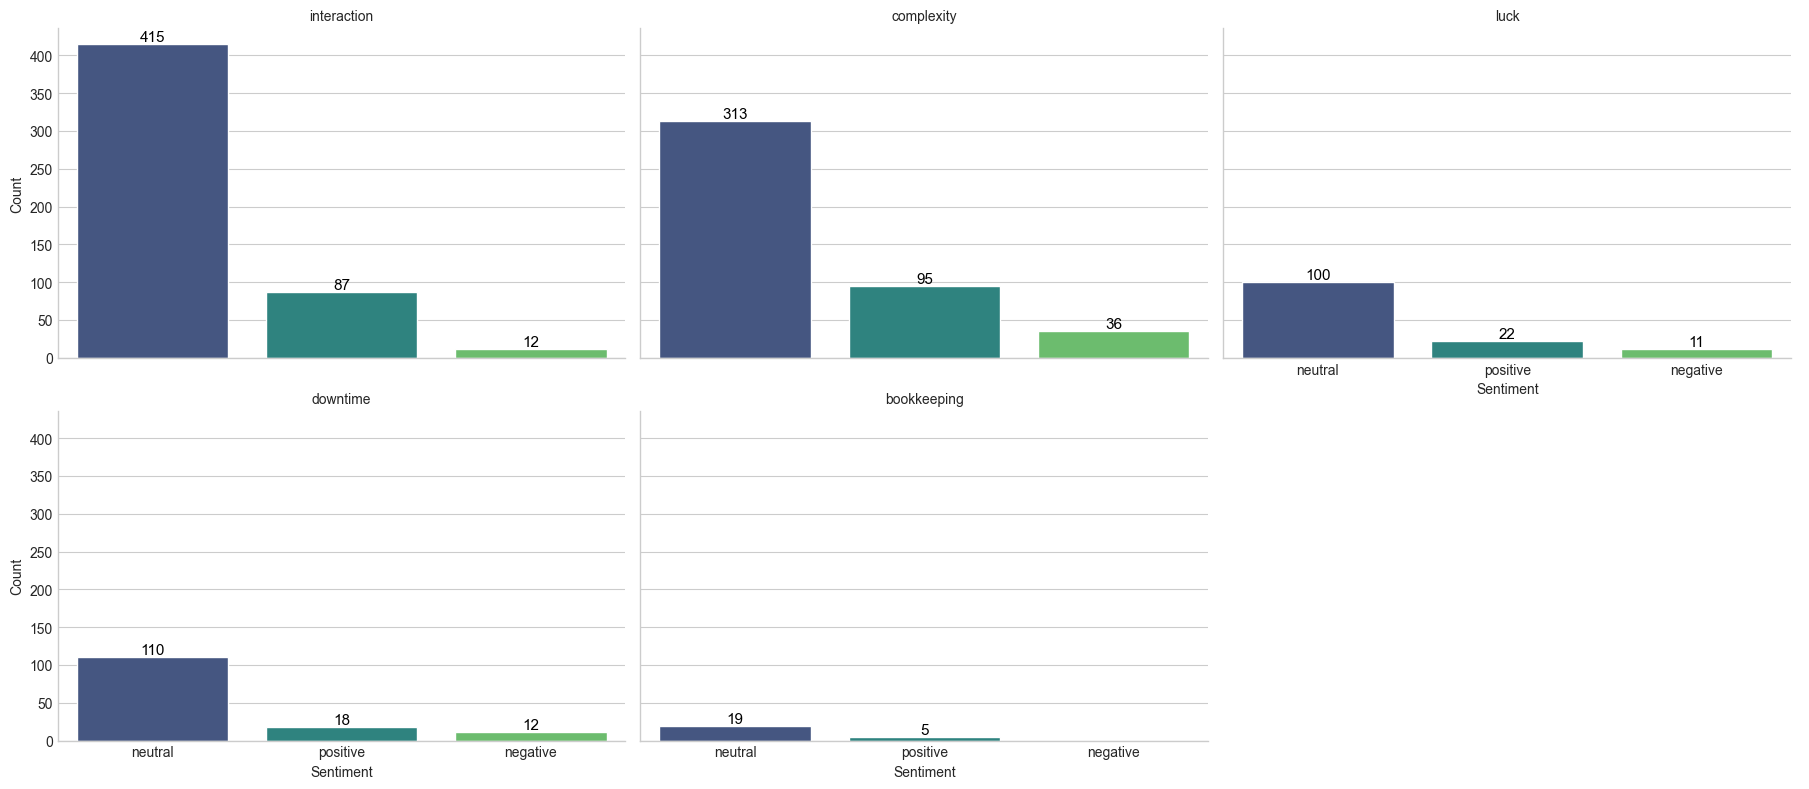

In [283]:
# Apply the FacetGrid plotting function
plot_facetgrid_sentiments(df_2_2, 'Sentiment_Score',game_id_to_filter)

We detect more polarity rate as neutral, because we are not more evaluating the sentence, but just the adjective related to the target words, that often are consdiered neutral. Here following also an example.

In [286]:
# analyze output results
sample_index = 0 # Change this to see different comments
sample_comment = df_2_2.iloc[sample_index]
# Display comments , etc.
print("Original Comment:")
print(sample_comment['Comment'])
print("\nRating:")
print(sample_comment['Comment_Rating'])
print("\nAdjective status in the sentences:")
print(sample_comment['Dependency_Aspect_Status'])
print("\nAdjective polarity with VADER of the adjectives:")
print(sample_comment['Sentiment_Dependence'])
print("\nAspect Sentiments:")
for aspect, sentiment in sample_comment['Sentiment_Score'].items():
    print(f"Aspect: {aspect}, Sentiment: {sentiment}")

Original Comment:
Good. There are so many things to do at once, no single player could try to dictate what others are doing.

Rating:
8.0

Adjective status in the sentences:
{player: [(single, 'positive')]}

Adjective polarity with VADER of the adjectives:
{player: (0.0, 'neutral')}

Aspect Sentiments:
Aspect: interaction, Sentiment: ['neutral']


## EXTRA - SUPPORT

In [287]:
#to understand token.dep_ in SPACY
nlp = spacy.load("en_core_web_sm")
for label in nlp.get_pipe("parser").labels:
    print(label, " -- ", spacy.explain(label))

ROOT  --  root
acl  --  clausal modifier of noun (adjectival clause)
acomp  --  adjectival complement
advcl  --  adverbial clause modifier
advmod  --  adverbial modifier
agent  --  agent
amod  --  adjectival modifier
appos  --  appositional modifier
attr  --  attribute
aux  --  auxiliary
auxpass  --  auxiliary (passive)
case  --  case marking
cc  --  coordinating conjunction
ccomp  --  clausal complement
compound  --  compound
conj  --  conjunct
csubj  --  clausal subject
csubjpass  --  clausal subject (passive)
dative  --  dative
dep  --  unclassified dependent
det  --  determiner
dobj  --  direct object
expl  --  expletive
intj  --  interjection
mark  --  marker
meta  --  meta modifier
neg  --  negation modifier
nmod  --  modifier of nominal
npadvmod  --  noun phrase as adverbial modifier
nsubj  --  nominal subject
nsubjpass  --  nominal subject (passive)
nummod  --  numeric modifier
oprd  --  object predicate
parataxis  --  parataxis
pcomp  --  complement of preposition
pobj  --  ob

In [288]:
# to understand token.pos_ possibilities of SPACY
for label in nlp.get_pipe("tagger").labels:
    print(label, " -- ", spacy.explain(label))

$  --  symbol, currency
''  --  closing quotation mark
,  --  punctuation mark, comma
-LRB-  --  left round bracket
-RRB-  --  right round bracket
.  --  punctuation mark, sentence closer
:  --  punctuation mark, colon or ellipsis
ADD  --  email
AFX  --  affix
CC  --  conjunction, coordinating
CD  --  cardinal number
DT  --  determiner
EX  --  existential there
FW  --  foreign word
HYPH  --  punctuation mark, hyphen
IN  --  conjunction, subordinating or preposition
JJ  --  adjective (English), other noun-modifier (Chinese)
JJR  --  adjective, comparative
JJS  --  adjective, superlative
LS  --  list item marker
MD  --  verb, modal auxiliary
NFP  --  superfluous punctuation
NN  --  noun, singular or mass
NNP  --  noun, proper singular
NNPS  --  noun, proper plural
NNS  --  noun, plural
PDT  --  predeterminer
POS  --  possessive ending
PRP  --  pronoun, personal
PRP$  --  pronoun, possessive
RB  --  adverb
RBR  --  adverb, comparative
RBS  --  adverb, superlative
RP  --  adverb, particle


In [55]:
# Step 1: Aspect extraction function
def extract_custom_aspects(text, aspect_keywords):
    found_aspects = []
    for aspect, keywords in aspect_keywords.items():
        # Check if any of the keywords related to the aspect are in the comment
        if any(keyword.lower() in text.lower() for keyword in keywords):
            found_aspects.append(aspect)
            for keyword in keywords:
                if keyword.lower() in text.lower():
                    print(keyword)
    return found_aspects

In [ ]:
# create a copy of orginal dataframe
df_comments_2_2_mod = df_comments.copy()

# Apply aspect extraction to all comments and create a 'custom_aspects' column
df_comments_2_2_mod['Custom_Aspects'] = df_comments_2_2_mod['Comment'].apply(lambda x: extract_custom_aspects(x, rev_train_dict))

# Filter the DataFrame to keep only rows where 'custom_aspects' is not an empty list
df_comments_2_2_mod = df_comments_2_2_mod[df_comments_2_2_mod['Custom_Aspects'].apply(lambda x: len(x) > 0)]
df_comments_2_2_mod

,Game_ID,Comment,Comment_Rating,Custom_Aspects
1,174430,Excellent game. Balancing issues with some cha...,8.5,"[downtime, interaction, complexity]"
5,174430,"After one play, not completing a dungeon I’m s...",7.0,[downtime]
6,174430,This game is a beast. So far my group has only...,9.0,"[luck, bookkeeping]"
10,174430,I kickstarted the 1st edition of Gloomhaven bu...,5.0,[bookkeeping]
11,174430,Gloomhaven is sold as D&D but better. It's not...,1.0,[luck]
...,...,...,...,...
88282,162886,"Every game is different from the previous one,...",10.0,[complexity]
88283,162886,My favorite co-op game of all time. It has so ...,10.0,[complexity]
88284,162886,Apparently I really love horror co-op games. T...,9.0,"[bookkeeping, complexity]"
88288,162886,Somehow this is a real brain teaser for me. Th...,7.0,[complexity]


In [57]:
ddd = df_comments_2_2_mod.iloc[:1,:]
ddd['new'] = ddd['Comment'].apply(lambda x: extract_custom_aspects(x, rev_train_dict))

hour
player
balance


In [69]:
# Unified function to detect adjectives and verb patterns with negation
def detect_adjectives_and_verbs(nlp_text, be_only=True):
    # Dictionary to store results with nouns/verbs and their associated adjectives
    results = {}
    # Step 1: Identify nouns and adjectives associated with them
    for token in nlp_text:
        if token.pos_ in ['NOUN', 'PROPN']:
            # Create an entry in the results dictionary for the noun
            results[token] = []
            # Explore adjectives linked to the noun, check for negation
            for child in token.children:
                if child.pos_ == 'ADJ':
                    # Check for negation dependency in children of the adjective
                    negated = any(c.dep_ == 'neg' for c in child.children)
                    results[token].append((child, "negated" if negated else "positive"))

    # Step 2: Identify verbs and associated adjectives (verb-adjective patterns)
    verbs = [x for x in nlp_text if (x.lemma_ == 'be' if be_only else x.pos_ in {'AUX', 'VERB'})]
    for verb in verbs:
        # Track adjectives or noun phrases associated with the verb
        verb_related = []
        for child in verb.children:
            # Check for adjectives directly associated with the verb
            if child.pos_ == 'ADJ':
                negated = any(c.dep_ == 'neg' for c in verb.children)
                verb_related.append((child, "negated" if negated else "positive"))
            # Check for noun phrases that could relate to the verb
            elif child.dep_ in ['dobj', 'attr', 'nsubj']:
                noun = child
                for noun_child in noun.children:
                    if noun_child.pos_ == 'ADJ':
                        negated = any(c.dep_ == 'neg' for c in noun_child.children)
                        verb_related.append((noun_child, "negated" if negated else "positive"))
        # If verb patterns found, add them to the results dictionary under the verb key
        if verb_related:
            results[verb] = verb_related

    return results

# Example usage
text = "The food is not delicious, and the service was amazing."
doc = nlp(text)
results = detect_adjectives_and_verbs(doc)
print(results)


{food: [], service: [], is: [(delicious, 'negated')], was: [(amazing, 'positive')]}


In [140]:
# Function to perform dependency parsing and sentiment analysis on aspects
def dependency_based_sentiment_vader(text, aspects, aspect_keywords):
    doc = nlp(text)
    aspect_sentiments = {}

    for aspect in aspects:
        for token in doc:
            # Check if the token matches an aspect keyword
            if token.lemma_.lower() in aspect_keywords[aspect]:
                # aspect_sentiments[aspect] = aspect_sentiments.get(aspect, 'neutral')  # Initialize to neutral
                
                # Examine children for adjectives, adverbs, or verbs
                for child in token.children:
                    # Check for sentiment-affecting dependencies
                    print(child)
                    if child.dep_ in ['amod', 'acomp', 'advmod', 'ROOT', 'attr', 'conj', 'xcomp', 'ccomp']:
                        # Detect negation in the child dependencies
                        negated = any(grandchild.dep_ == 'neg' for grandchild in child.children)

                        # Get the sentiment score
                        sentiment_score = analyzer.polarity_scores(child.text)
                        compound_score = sentiment_score['compound']
                        
                        # Adjust sentiment if negated
                        if negated:
                            compound_score = -compound_score  # Flip the sentiment polarity

                        # Determine sentiment based on adjusted compound score
                        if compound_score >= 0.05:
                            aspect_sentiments[aspect] = 'positive'
                        elif compound_score <= -0.05:
                            aspect_sentiments[aspect] = 'negative'
                        else:
                            aspect_sentiments[aspect] = 'neutral'
                        print(compound_score)

    return aspect_sentiments

the
unfair
unfair
-0.4767
fair
fair
0.3182
{'downtime': 'positive'}


In [58]:
# Apply sentiment analysis based on dependency parsing using VADER
df_comments_vader = df_comments_2_2_mod.copy()
df_comments_vader['Dependency_aspect_sentiments'] = df_comments_vader.apply(
    lambda row: dependency_based_sentiment_vader(row['Comment'], row['Custom_aspects'],rev_train_dict), axis=1)

# Filter the DataFrame to keep only rows where 'custom_aspects' is not an empty list
df_comments_vader = df_comments_vader[df_comments_vader['Dependency_aspect_sentiments'].apply(lambda x: len(x) > 0)]
df_comments_vader

,Game_ID,Comment,Comment_Rating,Custom_aspects,Dependency_aspect_sentiments
6,174430,This game is a beast. So far my group has only...,9.0,"[luck, bookkeeping]",{'luck': 'neutral'}
11,174430,Gloomhaven is sold as D&D but better. It's not...,1.0,[luck],{'luck': 'positive'}
16,174430,"Very mechanical, abstract and repetitive, and ...",5.0,"[bookkeeping, downtime, complexity]","{'bookkeeping': 'neutral', 'downtime': 'negati..."
19,174430,Thematic games and RPGs are not my cup of tea ...,3.0,"[luck, bookkeeping]",{'bookkeeping': 'positive'}
22,174430,Positives: Well produced game with solid mecha...,7.0,[luck],{'luck': 'positive'}
...,...,...,...,...,...
88196,162886,"I really love this game, it feels like a more ...",10.0,"[luck, complexity]","{'luck': 'neutral', 'complexity': 'neutral'}"
88197,162886,I don’t understand the hype at all! The arbitr...,3.0,[luck],{'luck': 'neutral'}
88206,162886,Low luck. Deepest coop game out there. So many...,9.9,[luck],{'luck': 'negative'}
88227,162886,Amazing solo/cooperative 'puzzle'. Game loop i...,9.8,"[downtime, complexity]","{'downtime': 'positive', 'complexity': 'positi..."


It is not possible to get sentiments for all che customer aspects found, it is linked to how the sentence is written

In [44]:
# analyze output results
sample_index = 4  # Change this to see different comments
sample_comment = df_comments_vader.iloc[sample_index]

print("Original Comment:")
print(sample_comment['Comment'])
print("\nAspect Sentiments:")
for aspect, sentiment in sample_comment['Dependency_aspect_sentiments'].items():
    print(f"Aspect: {aspect}, Sentiment: {sentiment}")

Original Comment:
Positives: Well produced game with solid mechanics Excellent art and interesting world. Amount of content and quality of design is extremely impressive.  Negatives: Game feels like work rather than play. Set up time is long (even with organizers). Fiddly and difficult.  Wanted to quit half-way through each play.  I may be in the minority, but I gave the game a fair chance and I've concluded that I don't enjoy playing it and will sell it soon.  Update:  I'm going to try Jaws of the Lion and see if I like it better.  I think I will without the overwhelming feeling of set-up and upkeep.

Aspect Sentiments:
Aspect: luck, Sentiment: positive


In [63]:
df_comments_vader.iloc[sample_index,1]

"Positives: Well produced game with solid mechanics Excellent art and interesting world. Amount of content and quality of design is extremely impressive.  Negatives: Game feels like work rather than play. Set up time is long (even with organizers). Fiddly and difficult.  Wanted to quit half-way through each play.  I may be in the minority, but I gave the game a fair chance and I've concluded that I don't enjoy playing it and will sell it soon.  Update:  I'm going to try Jaws of the Lion and see if I like it better.  I think I will without the overwhelming feeling of set-up and upkeep."

In [68]:
dependency_based_sentiment_vader(df_comments_vader.iloc[sample_index,1], ["luck"],rev_train_dict)

chance
a
fair
{'neg': 0.0, 'neu': 0.0, 'pos': 1.0, 'compound': 0.3182}


{'luck': 'positive'}

In [6]:
aspects = ['components', 'rules', 'gameplay', 'replayability', 'theme', 'complexity']

In [88]:
# Load the Hugging Face sentiment analysis pipeline
sentiment_pipeline = pipeline("sentiment-analysis", model="distilbert-base-uncased-finetuned-sst-2-english",truncation=True)

# Define a dictionary of aspects and associated keywords
aspect_keywords = {
    'luck': ['luck', 'random', 'chance', 'fortune', 'lucky', 'unlucky'],
    'downtime': ['downtime', 'waiting', 'slow', 'time between turns', 'lag', 'delay'],
    'interaction': ['interaction', 'engagement', 'social', 'cooperation', 'conflict', 'competitive'],
    'complication': ['complication', 'confusion', 'complex', 'convoluted', 'difficult'],
    'complexity': ['complexity', 'depth', 'strategy', 'involved', 'intricate'],
    'read rule book': ['rules', 'rulebook', 'instruction', 'manual', 'how to play', 'guide']
}

def extract_custom_aspects(text, aspect_keywords):
    found_aspects = []
    for aspect, keywords in aspect_keywords.items():
        # Check if any of the keywords related to the aspect are in the comment
        if any(keyword.lower() in text.lower() for keyword in keywords):
            found_aspects.append(aspect)
    return found_aspects

# Helper function to split long text into smaller chunks based on token limit
def split_text_into_chunks(text, tokenizer, max_tokens=512):
    sentences = nltk.sent_tokenize(text)
    current_chunk = []
    current_length = 0
    chunks = []
    
    for sentence in sentences:
        sentence_length = len(tokenizer.encode(sentence, add_special_tokens=False))
        
        # If adding this sentence exceeds the limit, save the current chunk and start a new one
        if current_length + sentence_length > max_tokens:
            chunks.append(' '.join(current_chunk))
            current_chunk = []
            current_length = 0
        
        current_chunk.append(sentence)
        current_length += sentence_length
    
    # Add the last chunk if it exists
    if current_chunk:
        chunks.append(' '.join(current_chunk))
    
    return chunks

def custom_aspect_sentiment_analysis(text, aspects, tokenizer, max_token_limit=512):
    sentences = nltk.sent_tokenize(text)
    aspect_sentiments = {}
    
    for aspect in aspects:
        # Find sentences that mention the aspect or its related keywords
        aspect_sentences = [sentence for sentence in sentences if any(keyword.lower() in sentence.lower() for keyword in aspect_keywords[aspect])]
        
        if aspect_sentences:
            aspect_text = ' '.join(aspect_sentences)

            # Split aspect_text into chunks if it exceeds the token limit
            if len(tokenizer.encode(aspect_text, add_special_tokens=False)) > max_token_limit:
                aspect_chunks = split_text_into_chunks(aspect_text, tokenizer, max_tokens=max_token_limit)
                sentiment_results = []
                sentiment_results_new = []
                for chunk in aspect_chunks:
                    sentiment = sentiment_pipeline(chunk)
                    sentiment_results.append(sentiment[0]['label'])
                    sentiment_results_new.append(sentiment[0])

                print(sentiment_results) ####NEW
                print(sentiment_results_new) ####NEW
                # Combine the sentiment results (majority vote for simplicity)
                combined_sentiment = max(set(sentiment_results), key=sentiment_results.count)
                print(set(sentiment_results)) ####NEW
                print(sentiment_results.count)####NEW
                print(combined_sentiment)####NEW
                combined_sentiment = max(set(sentiment_results['label']), key=sentiment_results.count)
                aspect_sentiments[aspect] = combined_sentiment
            else:
                # For short text, just run the sentiment analysis directly
                sentiment = sentiment_pipeline(aspect_text)
                #aspect_sentiments[aspect] = sentiment[0]['label']
                aspect_sentiments[aspect] = sentiment[0]
    
    return aspect_sentiments

In [89]:
# Apply aspect extraction
df_comments['custom_aspects'] = df_comments['comment'].apply(lambda x: extract_custom_aspects(x, aspect_keywords))

# Apply aspect-based sentiment analysis with text splitting
df_comments['custom_aspect_sentiments'] = df_comments.apply(
    lambda row: custom_aspect_sentiment_analysis(row['comment'], row['custom_aspects'], tokenizer=sentiment_pipeline.tokenizer), axis=1)

# Display results
print(df_comments[['comment', 'custom_aspects', 'custom_aspect_sentiments']].head())

Token indices sequence length is longer than the specified maximum sequence length for this model (1001 > 512). Running this sequence through the model will result in indexing errors


['POSITIVE', 'NEGATIVE']
[{'label': 'POSITIVE', 'score': 0.748120903968811}, {'label': 'NEGATIVE', 'score': 0.9833974242210388}]
{'POSITIVE', 'NEGATIVE'}
<built-in method count of list object at 0x0000020FD797CA80>
POSITIVE


TypeError: list indices must be integers or slices, not str

In [65]:
# Filter the DataFrame to keep only rows where 'custom_aspects' is not an empty list
df_comments_filtered = df_comments[df_comments['custom_aspects'].apply(lambda x: len(x) > 0)]

# Display the filtered DataFrame
df_comments_filtered

,Game ID,Game Name,comment,custom_aspects,custom_aspect_sentiments
11,358661,Andromeda's Edge,pledged waiting delivery,[downtime],{'downtime': 'NEGATIVE'}
12,358661,Andromeda's Edge,like doe game worker placement game core actio...,"[downtime, read rule book]","{'downtime': 'POSITIVE', 'read rule book': 'PO..."
24,358661,Andromeda's Edge,game relatively easy teach play great componen...,[luck],{'luck': 'POSITIVE'}
28,358661,Andromeda's Edge,best worker placement game ive yet played over...,"[luck, complexity, read rule book]","{'luck': 'POSITIVE', 'complexity': 'POSITIVE',..."
33,358661,Andromeda's Edge,enjoy whatever strategy plan destroyed bad rol...,"[luck, complexity]","{'luck': 'NEGATIVE', 'complexity': 'NEGATIVE'}"
...,...,...,...,...,...
962,12,Ra,close perfect game depth system elegant compon...,[complexity],{'complexity': 'POSITIVE'}
967,12,Ra,happy play every play often enough request gam...,[luck],{'luck': 'POSITIVE'}
977,420385,The Yellow House,interesting hand shedder dont want necessarily...,[downtime],{'downtime': 'NEGATIVE'}
984,420385,The Yellow House,designer geonil playing time min weight publis...,"[luck, downtime, interaction, complication, co...","{'luck': 'NEGATIVE', 'downtime': 'NEGATIVE', '..."


In [68]:
#df_comments_filtered['comment'][967]

# analyze output results
sample_index = 2  # Change this to see different comments
sample_comment = df_comments_filtered.iloc[sample_index]

print("Original Comment:")
print(sample_comment['comment'])
print("\nAspect Sentiments:")
for aspect, sentiment in sample_comment['custom_aspect_sentiments'].items():
    print(f"Aspect: {aspect}, Sentiment: {sentiment['label']}, Score: {sentiment['score']:.2f}")


Original Comment:
game relatively easy teach play great components deluxe combat luck based mitigation increasing number dice number ships combat occasional effects immensely fun surprise lot races chose asymmetric tactical cards meaningful fun play raiders fun combat rarely menace game session might run longer side despite basic actions commerce track might difference winning lose found occupies enormous table space

Aspect Sentiments:


TypeError: string indices must be integers, not 'str'

In [27]:
# Convert 'custom_aspect_sentiments' into a list of (aspect, sentiment) pairs for easy analysis
aspect_sentiment_pairs = []

for index, row in df_comments.iterrows():
    aspect_sentiments = row['custom_aspect_sentiments']
    game_name = row['Game Name']
    for aspect, sentiment in aspect_sentiments.items():
        aspect_sentiment_pairs.append((game_name,aspect, sentiment))

# Create a DataFrame for aspect-sentiment pairs
df_aspect_sentiments = pd.DataFrame(aspect_sentiment_pairs, columns=['Game Name','Aspect', 'Sentiment'])
df_aspect_sentiments

,Game Name,Aspect,Sentiment
0,Andromeda's Edge,downtime,NEGATIVE
1,Andromeda's Edge,downtime,POSITIVE
2,Andromeda's Edge,read rule book,POSITIVE
3,Andromeda's Edge,luck,POSITIVE
4,Andromeda's Edge,luck,NEGATIVE
...,...,...,...
275,The Yellow House,interaction,NEGATIVE
276,The Yellow House,complication,NEGATIVE
277,The Yellow House,complexity,POSITIVE
278,The Yellow House,read rule book,POSITIVE


In [ ]:
def aspect_based_sentiment_analysis(text):
    results = {}
    sentences = nltk.sent_tokenize(text)
    for aspect in aspects:
        aspect_sentences = [sentence for sentence in sentences if aspect in sentence.lower()]
        if aspect_sentences:
            aspect_text = ' '.join(aspect_sentences)
            sentiment = sentiment_pipeline(aspect_text)
            results[aspect] = sentiment[0]
    return results

df_comments['aspect_sentiments'] = df_comments['comment'].apply(aspect_based_sentiment_analysis)


In [90]:
# Step 1: Load models
from transformers import AutoTokenizer, AutoModelForTokenClassification, pipeline
from transformers import pipeline as sentiment_pipeline
import nltk

# Initialize NER and Sentiment Analysis pipelines
tokenizer = AutoTokenizer.from_pretrained("dbmdz/bert-large-cased-finetuned-conll03-english")
model = AutoModelForTokenClassification.from_pretrained("dbmdz/bert-large-cased-finetuned-conll03-english")
ner_pipeline = pipeline("ner", model=model, tokenizer=tokenizer, grouped_entities=True)
sentiment_pipeline = pipeline('sentiment-analysis')

# Step 2: Aspect extraction function
def extract_aspects(text):
    ner_results = ner_pipeline(text)
    aspects = [entity['word'] for entity in ner_results if entity['entity_group'] in ['ORG', 'MISC', 'PER', 'LOC']]
    return aspects

# Step 3: Sentiment Analysis function
def aspect_sentiment_analysis(text, aspects):
    sentences = nltk.sent_tokenize(text)
    aspect_sentiments = {}
    for aspect in aspects:
        aspect_sentences = [sentence for sentence in sentences if aspect in sentence]
        if aspect_sentences:
            aspect_text = ' '.join(aspect_sentences)
            sentiment = sentiment_pipeline(aspect_text)
            aspect_sentiments[aspect] = sentiment[0]['label']
    return aspect_sentiments

Some weights of the model checkpoint at dbmdz/bert-large-cased-finetuned-conll03-english were not used when initializing BertForTokenClassification: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
C:\Users\ZStravij\AppData\Local\Programs\Python\Python311\Lib\site-packages\transformers\pipelines\token_classification.py:170: UserWarning: `grouped_entities` is deprecated and will be removed in version v5.0.0, defaulted to `aggregation_strategy="AggregationStrategy.SIMPLE"` instead.
  warnings.warn(
No mo

In [ ]:
df_comments['aspects'] = df_comments['comment'].apply(extract_aspects)
df_comments['aspect_sentiments'] = df_comments.apply(
    lambda row: aspect_sentiment_analysis(row['comment'], row['aspects']), axis=1)

print(df_comments[['comment', 'aspects', 'aspect_sentiments']].head())

In [92]:
from gensim import corpora, models

# Tokenize the text and prepare the data for LDA
tokenized_comments = [nltk.word_tokenize(comment.lower()) for comment in df_comments['comment']]
dictionary = corpora.Dictionary(tokenized_comments)
corpus = [dictionary.doc2bow(text) for text in tokenized_comments]

# Train the LDA model
lda_model = models.LdaModel(corpus, num_topics=6, id2word=dictionary, passes=15)

# Print topics and their top words
topics = lda_model.print_topics(num_words=5)
for topic in topics:
    print(topic)


(0, '0.024*":" + 0.018*"." + 0.017*"the" + 0.011*"and" + 0.011*"]"')
(1, '0.063*"." + 0.024*"the" + 0.023*"game" + 0.021*"is" + 0.018*","')
(2, '0.045*"." + 0.043*"the" + 0.037*"," + 0.026*"to" + 0.026*"and"')
(3, '0.041*"the" + 0.038*"," + 0.026*"." + 0.022*"to" + 0.016*"a"')
(4, '0.046*"." + 0.043*"the" + 0.036*"," + 0.022*"to" + 0.022*"a"')
(5, '0.093*":" + 0.028*":star" + 0.027*")" + 0.025*"(" + 0.018*"the"')


In [ ]:
tokenized_comments[0:5]

In [ ]:
#pip install aspect_based_sentiment_analysis

In [ ]:
#pip install tf-keras

In [ ]:
# below it is not working due --> RecursionError: maximum recursion depth exceeded